In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D 
from rdkit.Chem import rdDepictor, Draw 
from glob import glob
from xyz2mol import xyz2mol, read_xyz_file
from rdkit.Chem.rdMolTransforms import GetAngleDeg, GetDihedralDeg

RDKit WARNING: [04:35:12] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
filepath_list = list(glob('./structures/*.xyz'))
filepath_list.sort()

mol_dict = {}
num_mols = len(filepath_list)
fails_path = []
for i in range(num_mols):
    filepath = filepath_list[i]
    atomicNumList, charge, xyz_coordinates = read_xyz_file(filepath)
    try:
        mol = xyz2mol(atomicNumList, 
                  charge, 
                  xyz_coordinates, 
                  charged_fragments=False, 
                  quick=True, 
                  huckel=False)
    except:
        fails_path.append(filepath)
    mol_dict[filepath[13:-4]] = mol

In [3]:
final = pd.read_csv('final.csv')

fails = len(fails_path)
fail_molecules = [i[13:-4] for i in fails_path]
fails_ = (pd.Series(fail_molecules).isin(final.molecule_name)).sum()
_ = len(final.loc[final.molecule_name.isin(fail_molecules)])
print('There are {} molecules that could not be read with RDKIT '
      'in structures.csv; {} of these molecules are present in '
      'DataFrame-final. There are {} relevant entries in final '
      'that cannot be read with RDKIT and therefore are temporarily '
      'removed.'.format(fails, fails_, _))

There are 366 molecules that could not be read with RDKIT in structures.csv; 234 of these molecules are present in DataFrame-final. There are 11058 relevant entries in final that cannot be read with RDKIT and therefore are temporarily removed.


In [4]:
len(final.molecule_name.unique()), len(final), len(mol_dict) # total number of molecules, entries in 'final' % total readable molecules

(85012, 4659076, 130789)

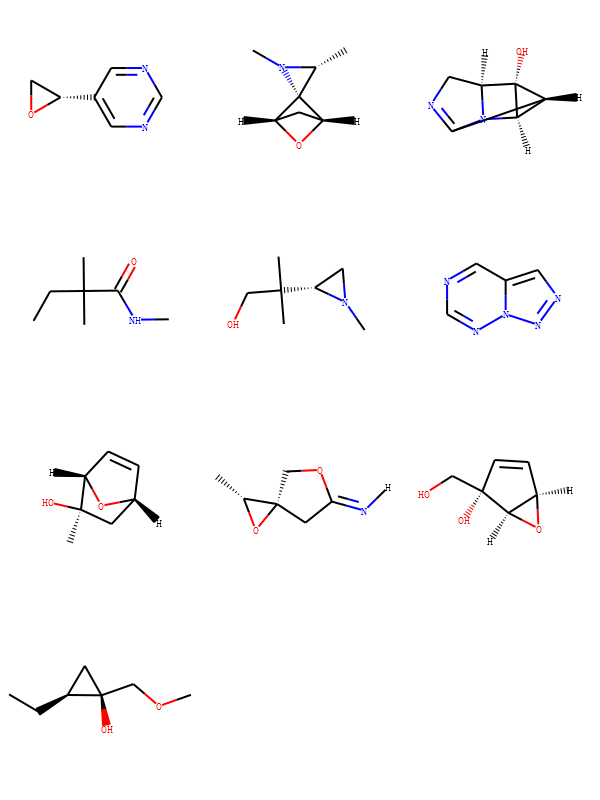

In [5]:
mols = np.random.choice(list(mol_dict.keys()), 10)
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol_dict[_])) for _ in mols], molsPerRow=3)

In [6]:
filtered = final.loc[~final.molecule_name.isin(fail_molecules)]
df = filtered.copy()
df_2jhh = df.loc[df.type == '2JHH'][['id', 'molecule_name', 'atom_index_0', 'atom_index_1']]
df_2jhc = df.loc[df.type == '2JHC'][['id', 'molecule_name', 'atom_index_0', 'atom_index_1']]
df_2jhn = df.loc[df.type == '2JHN'][['id', 'molecule_name', 'atom_index_0', 'atom_index_1']]

In [7]:
df_2jhh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377092 entries, 1 to 4659049
Data columns (total 4 columns):
id               377092 non-null int64
molecule_name    377092 non-null object
atom_index_0     377092 non-null int64
atom_index_1     377092 non-null int64
dtypes: int64(3), object(1)
memory usage: 14.4+ MB


In [8]:
df_2jhc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138492 entries, 22 to 4659074
Data columns (total 4 columns):
id               1138492 non-null int64
molecule_name    1138492 non-null object
atom_index_0     1138492 non-null int64
atom_index_1     1138492 non-null int64
dtypes: int64(3), object(1)
memory usage: 43.4+ MB


In [9]:
df_2jhn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118464 entries, 18 to 4659059
Data columns (total 4 columns):
id               118464 non-null int64
molecule_name    118464 non-null object
atom_index_0     118464 non-null int64
atom_index_1     118464 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.5+ MB


In [10]:
def degree_2J(m, atom_index_0, atom_index_1):
    atom0 = m.GetAtomWithIdx(atom_index_0)
    if atom0.GetAtomicNum() == 1:
        neighbor = atom0.GetNeighbors()[0].GetIdx() 
        # for 2J coupling between H and another atom, 
        # there could be only one common neighbor,
        # because H has valence of 1, 
        # so only the first neighbor is selected using index 0
    else:
        neighbor = m.GetAtomWithIdx(atom_index_1).GetNeighbors()[0].GetIdx()
    return np.mean([GetAngleDeg(conf, atom_index_0, neighbor, atom_index_1) for conf in m.GetConformers()])
def getdegree(df, func):
    for row in df.itertuples():
        m = mol_dict[row.molecule_name]
        #print(m)
        try:
            df.at[row.Index, 'degree'] = func(m, row.atom_index_0, row.atom_index_1)
        except:
            df.at[row.Index, 'degree'] = np.nan
        
    return df
#degree_2J(mol_dict['dsgdb9nsd_000001'], 1, 2)

In [11]:
%%time
getdegree(df_2jhh, degree_2J)
getdegree(df_2jhn, degree_2J)
getdegree(df_2jhc, degree_2J)

Wall time: 1min 22s


,id,molecule_name,atom_index_0,atom_index_1,degree
22,22,dsgdb9nsd_000007,2,1,111.442962
29,29,dsgdb9nsd_000007,3,1,111.442320
35,35,dsgdb9nsd_000007,4,1,111.445879
39,39,dsgdb9nsd_000007,5,0,111.442176
43,43,dsgdb9nsd_000007,6,0,111.442433
...,...,...,...,...,...
4659064,4659064,dsgdb9nsd_133884,16,6,121.222737
4659066,4659066,dsgdb9nsd_133884,16,8,120.420593
4659070,4659070,dsgdb9nsd_133884,17,3,123.704137
4659071,4659071,dsgdb9nsd_133884,17,4,122.939931


In [12]:
df_2jhc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1138492 entries, 22 to 4659074
Data columns (total 5 columns):
id               1138492 non-null int64
molecule_name    1138492 non-null object
atom_index_0     1138492 non-null int64
atom_index_1     1138492 non-null int64
degree           1138492 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 52.1+ MB


In [13]:
df_2jhn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118464 entries, 18 to 4659059
Data columns (total 5 columns):
id               118464 non-null int64
molecule_name    118464 non-null object
atom_index_0     118464 non-null int64
atom_index_1     118464 non-null int64
degree           118464 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 10.4+ MB


In [14]:
df_2jhh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377092 entries, 1 to 4659049
Data columns (total 5 columns):
id               377092 non-null int64
molecule_name    377092 non-null object
atom_index_0     377092 non-null int64
atom_index_1     377092 non-null int64
degree           377092 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 27.3+ MB


In [15]:
df_2jhc = pd.merge(filtered, df_2jhc,
                   on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])
df_2jhn = pd.merge(filtered, df_2jhn,
                   on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])
df_2jhh = pd.merge(filtered, df_2jhh,
                   on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])

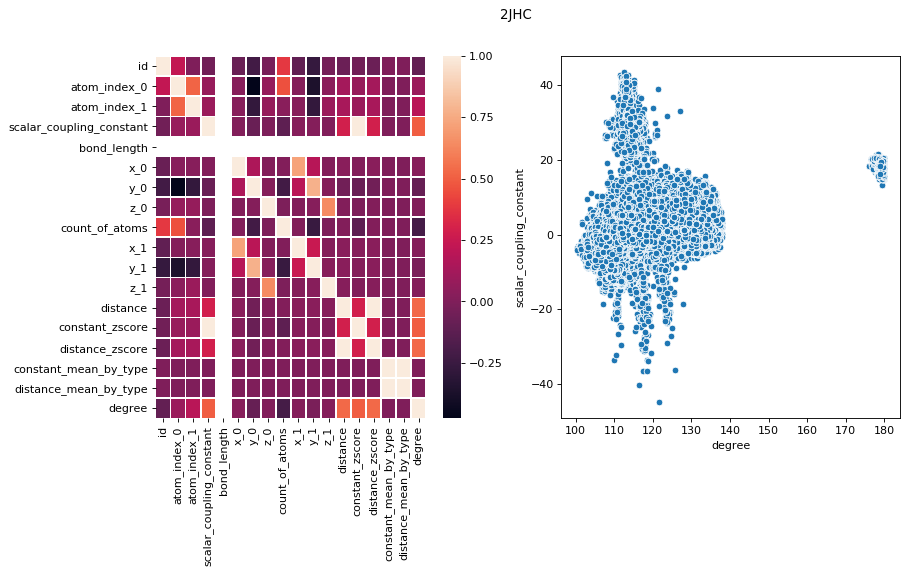

In [16]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.heatmap(df_2jhc.corr(method='pearson'), linewidth=.5)

plt.subplot(122)
sns.scatterplot(x='degree', y='scalar_coupling_constant', data=df_2jhc)

plt.suptitle('2JHC') 
plt.show()

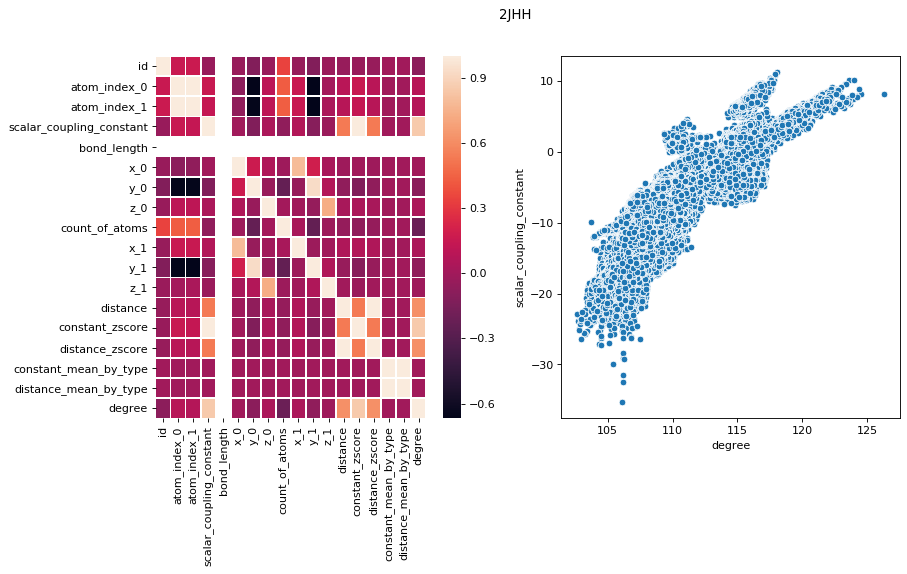

In [17]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.heatmap(df_2jhh.corr(method='pearson'), linewidth=.5)

plt.subplot(122)
sns.scatterplot(x='degree', y='scalar_coupling_constant', data=df_2jhh)

plt.suptitle('2JHH') 
plt.show()

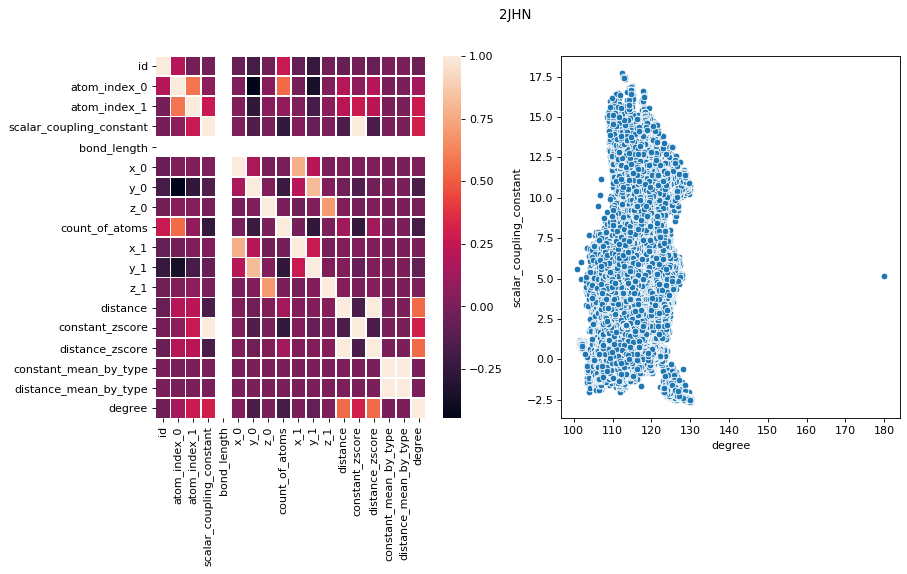

In [18]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.heatmap(df_2jhn.corr(method='pearson'), linewidth=.5)

plt.subplot(122)
sns.scatterplot(x='degree', y='scalar_coupling_constant', data=df_2jhn)

plt.suptitle('2JHN') 
plt.show()

In [19]:
df_3jhh = df.loc[df.type == '3JHH'][['id', 'molecule_name', 'atom_index_0', 'atom_index_1']]
df_3jhc = df.loc[df.type == '3JHC'][['id', 'molecule_name', 'atom_index_0', 'atom_index_1']]
df_3jhn = df.loc[df.type == '3JHN'][['id', 'molecule_name', 'atom_index_0', 'atom_index_1']]

In [20]:
df_3jhh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588990 entries, 25 to 4659067
Data columns (total 4 columns):
id               588990 non-null int64
molecule_name    588990 non-null object
atom_index_0     588990 non-null int64
atom_index_1     588990 non-null int64
dtypes: int64(3), object(1)
memory usage: 22.5+ MB


In [21]:
df_3jhc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1508194 entries, 60 to 4659073
Data columns (total 4 columns):
id               1508194 non-null int64
molecule_name    1508194 non-null object
atom_index_0     1508194 non-null int64
atom_index_1     1508194 non-null int64
dtypes: int64(3), object(1)
memory usage: 57.5+ MB


In [22]:
df_3jhn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165733 entries, 75 to 4659068
Data columns (total 4 columns):
id               165733 non-null int64
molecule_name    165733 non-null object
atom_index_0     165733 non-null int64
atom_index_1     165733 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.3+ MB


In [23]:
def find_neighbors(m, idx):
    neighbor = [x.GetIdx() for x in m.GetAtomWithIdx(idx).GetNeighbors()]
    return neighbor 

  
def degree_3J(m, atom_index_0, atom_index_1):
    atom0 = m.GetAtomWithIdx(atom_index_0)
    if atom0.GetAtomicNum() == 1:
        immediate0 = atom0.GetNeighbors()[0].GetIdx() 
        # immediate neighbor of 0
        # for 3J coupling between H and another atom, 
        # H could only have one neighbor,
        # because H has valence of 1, 
        # so only the first neighbor is selected using index 0
        secondary = find_neighbors(m, immediate0) # immediate neighbors of 0
        secondary.remove(atom_index_0) #remove atom0 from its own secondary neighbor
        for i in secondary:
            third = find_neighbors(m, i)
            third.remove(immediate0)
            if atom_index_1 in third:
                immediate1 = i
                return np.mean([GetDihedralDeg(conf, atom_index_0, immediate0, immediate1, atom_index_1) for conf in m.GetConformers()])
    else:
        immediate1 = atom1.GetNeighbors()[0].GetIdx()
        secondary = find_neighbors(m, immediate1) 
        secondary.remove(atom_index_1)
        for i in secondary:
            third = find_neighbors(m, i)
            third.remove(immediate1)
            if atom_index_0 in third:
                immediate0 = i
                return np.mean([GetDihedralDeg(conf, atom_index_0, immediate0, immediate1, atom_index_1) for conf in m.GetConformers()])

def degree_3JHH(m, atom_index_0, atom_index_1):
    atom0 = m.GetAtomWithIdx(atom_index_0)
    immediate0 = atom0.GetNeighbors()[0].GetIdx() 
    atom1 = m.GetAtomWithIdx(atom_index_1)
    immediate1 = atom1.GetNeighbors()[0].GetIdx() 
   
    return np.mean([GetDihedralDeg(conf, atom_index_0, immediate0, immediate1, atom_index_1) for conf in m.GetConformers()])

In [24]:
%%time
getdegree(df_3jhh, degree_3JHH)
getdegree(df_3jhn, degree_3J)
getdegree(df_3jhc, degree_3J)

Wall time: 2min 19s


,id,molecule_name,atom_index_0,atom_index_1,degree
60,60,dsgdb9nsd_000009,3,2,140.615151
65,65,dsgdb9nsd_000009,4,2,-99.386230
69,69,dsgdb9nsd_000009,5,2,20.614420
70,70,dsgdb9nsd_000009,6,0,39.506990
110,110,dsgdb9nsd_000013,3,2,-59.783456
...,...,...,...,...,...
4659062,4659062,dsgdb9nsd_133884,16,4,118.724282
4659063,4659063,dsgdb9nsd_133884,16,5,-94.314707
4659069,4659069,dsgdb9nsd_133884,17,2,-145.642451
4659072,4659072,dsgdb9nsd_133884,17,5,144.431249


In [25]:
#m = mol_dict['dsgdb9nsd_000024']
#m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m)); m_2d #linear molecule does not have dihedral angle

In [26]:
df_3jhc = pd.merge(filtered, df_3jhc,
                   on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])
df_3jhn = pd.merge(filtered, df_3jhn,
                   on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])
df_3jhh = pd.merge(filtered, df_3jhh,
                   on=['id', 'molecule_name', 'atom_index_0', 'atom_index_1'])

In [27]:
df_3jhh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588990 entries, 0 to 588989
Data columns (total 22 columns):
id                          588990 non-null int64
molecule_name               588990 non-null object
atom_index_0                588990 non-null int64
atom_index_1                588990 non-null int64
type                        588990 non-null object
scalar_coupling_constant    588990 non-null float64
bond_length                 588990 non-null int64
atom_0                      588990 non-null object
atom_1                      588990 non-null object
x_0                         588990 non-null float64
y_0                         588990 non-null float64
z_0                         588990 non-null float64
count_of_atoms              588990 non-null int64
x_1                         588990 non-null float64
y_1                         588990 non-null float64
z_1                         588990 non-null float64
distance                    588990 non-null float64
constant_zscore    

In [28]:
df_3jhn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165733 entries, 0 to 165732
Data columns (total 22 columns):
id                          165733 non-null int64
molecule_name               165733 non-null object
atom_index_0                165733 non-null int64
atom_index_1                165733 non-null int64
type                        165733 non-null object
scalar_coupling_constant    165733 non-null float64
bond_length                 165733 non-null int64
atom_0                      165733 non-null object
atom_1                      165733 non-null object
x_0                         165733 non-null float64
y_0                         165733 non-null float64
z_0                         165733 non-null float64
count_of_atoms              165733 non-null int64
x_1                         165733 non-null float64
y_1                         165733 non-null float64
z_1                         165733 non-null float64
distance                    165733 non-null float64
constant_zscore    

In [29]:
df_3jhc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1508194 entries, 0 to 1508193
Data columns (total 22 columns):
id                          1508194 non-null int64
molecule_name               1508194 non-null object
atom_index_0                1508194 non-null int64
atom_index_1                1508194 non-null int64
type                        1508194 non-null object
scalar_coupling_constant    1508194 non-null float64
bond_length                 1508194 non-null int64
atom_0                      1508194 non-null object
atom_1                      1508194 non-null object
x_0                         1508194 non-null float64
y_0                         1508194 non-null float64
z_0                         1508194 non-null float64
count_of_atoms              1508194 non-null int64
x_1                         1508194 non-null float64
y_1                         1508194 non-null float64
z_1                         1508194 non-null float64
distance                    1508194 non-null float64


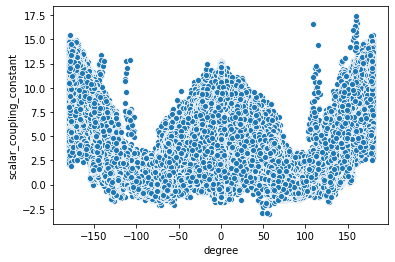

In [30]:
sns.scatterplot(x='degree', y='scalar_coupling_constant', data=df_3jhh)
plt.show()

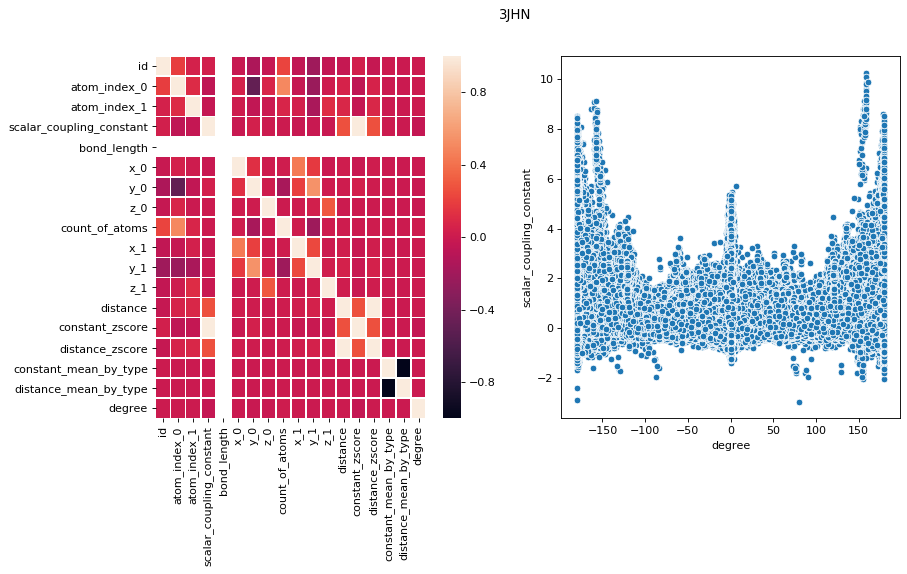

In [31]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.heatmap(df_3jhn.corr(method='pearson'), linewidth=.5)

plt.subplot(122)
sns.scatterplot(x='degree', y='scalar_coupling_constant', data=df_3jhn)

plt.suptitle('3JHN') 
plt.show()

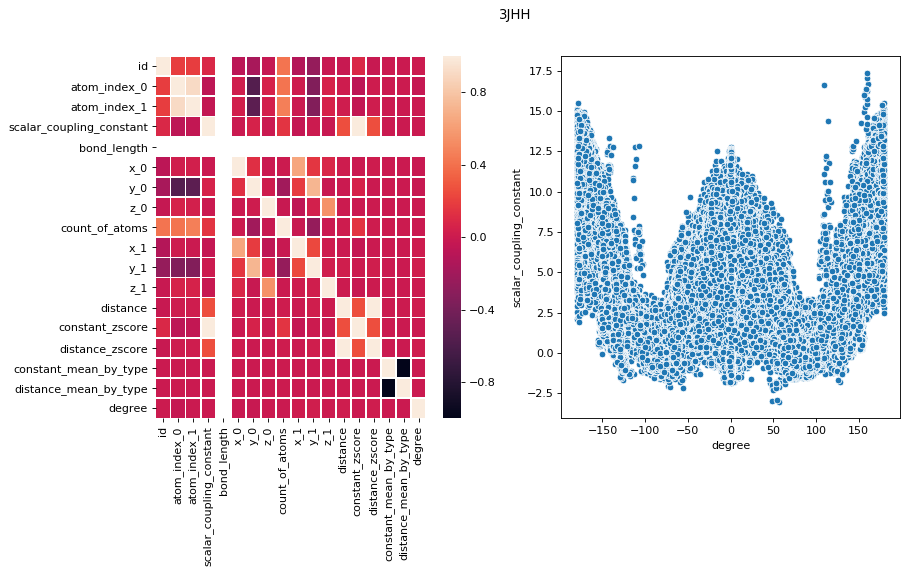

In [32]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.heatmap(df_3jhh.corr(method='pearson'), linewidth=.5)

plt.subplot(122)
sns.scatterplot(x='degree', y='scalar_coupling_constant', data=df_3jhh)

plt.suptitle('3JHH') 
plt.show()

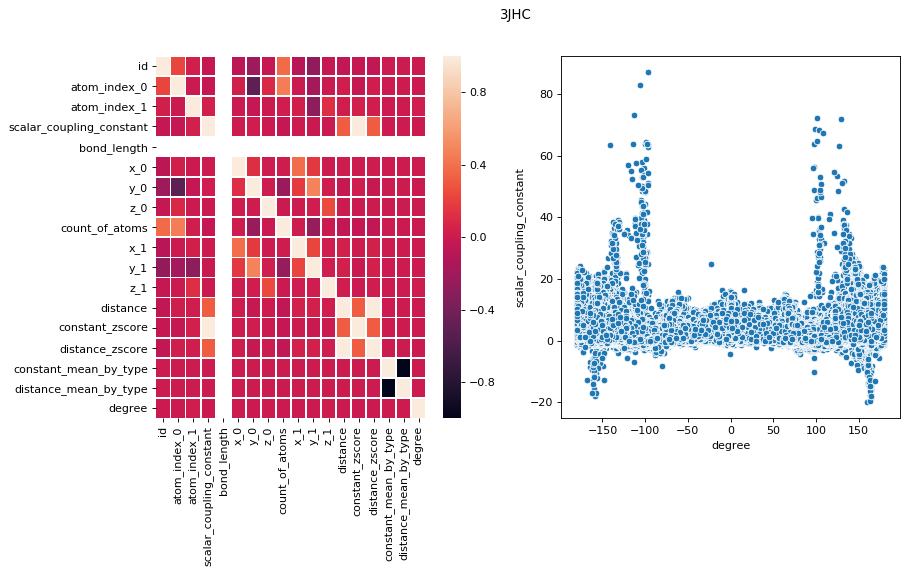

In [33]:
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.heatmap(df_3jhc.corr(method='pearson'), linewidth=.5)

plt.subplot(122)
sns.scatterplot(x='degree', y='scalar_coupling_constant', data=df_3jhc)

plt.suptitle('3JHC') 
plt.show()

In [34]:
def pearson_r(x, y): return np.corrcoef(x, y)[0,1]

def correlation(s, d, n):
    r_obs = pearson_r(s,d)

    perm_replicates = np.empty(n)
    for i in range(len(perm_replicates)):
        s_permuted = np.random.permutation(s)
        perm_replicates[i] = pearson_r(s_permuted, d)


    p = np.sum(perm_replicates >= r_obs)/n
    return r_obs, p

In [35]:
df_3JHN = final.loc[final.type=='3JHN'][['scalar_coupling_constant', 'distance']]
s = df_3JHN.scalar_coupling_constant
d = df_3JHN.distance
r_obs, p = correlation(s, d, 1000)
print('Observed pearson r value is {}. ' 
      'Null Hypothsis: distance and scalar coupling constant are not correlated for coupling type 3JHN. ' 
      'p value = {}.'.format(r_obs,p))

Observed pearson r value is 0.2720233999618892. Null Hypothsis: distance and scalar coupling constant are not correlated for coupling type 3JHN. p value = 0.0.


In [36]:
df_2JHN = final.loc[final.type=='2JHN'][['scalar_coupling_constant', 'distance']]
s = df_2JHN.scalar_coupling_constant
d = df_2JHN.distance
r_obs, p = correlation(s, d, 1000)
print('Observed pearson r value is {}. ' 
      'Null Hypothsis: distance and scalar coupling constant are not correlated for coupling type 2JHN. ' 
      'p value = {}. '.format(r_obs,p))

Observed pearson r value is -0.16060371557794048. Null Hypothsis: distance and scalar coupling constant are not correlated for coupling type 2JHN. p value = 1.0. 


In [37]:
df_3JHH = final.loc[final.type=='3JHH'][['scalar_coupling_constant', 'distance']]
s = df_3JHH.scalar_coupling_constant
d = df_3JHH.distance
r_obs, p = correlation(s, d, 1000)
print('Observed pearson r value is {}. ' 
      'Null Hypothsis: distance and scalar coupling constant are not correlated for coupling type 3JHH. ' 
      'p value = {}.'.format(r_obs,p))

Observed pearson r value is 0.2637297564673893. Null Hypothsis: distance and scalar coupling constant are not correlated for coupling type 3JHH. p value = 0.0.
